In [1]:
import scanpy as sc
import sctk

sc.settings.set_figure_params(dpi=80)

This notebook will show how to apply SCTK's automatic QC workflow. The process has four steps:
 - `sctk.calculate_qc()` computes QC measures
 - `sctk.generate_qc_clusters()` creates QC-space clusters of cells
 - `sctk.filter_qc_outlier()` performs cell-level QC calling
 - `sctk.find_good_qc_cluster()` computes cluster-wide statistics of cell quality

Let's use Scanpy's PBMC object as input.

In [2]:
adata = sc.datasets.pbmc3k()
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

This object features raw counts for some PBMC data, and nothing else for now. We can use `sctk.calculate_qc()` to automatically flag some common technical features (the defaults are human mitochondrial, ribosomal and hemoglobin genes) and subsequently use `sc.pp.calculate_qc_metrics()` to compute their percentages in each cell, along with standard measures like the number of genes and counts.

In [3]:
sctk.calculate_qc(adata)
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    obs: 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50'
    var: 'gene_ids', 'mito', 'ribo', 'hb', 'n_counts', 'n_cells'

You can see the `.obs` of the object populated with the QC measures we just generated.

The second step of the QC workflow is to cluster the cells based on specified metrics, performing a quick Scanpy analysis using the metrics as features. This creates groups of cells that have similar QC profiles.

In [4]:
#present as columns in obs of the object
metrics_list = ["log1p_n_counts", "log1p_n_genes", "percent_mito", "percent_ribo", "percent_hb"]
sctk.generate_qc_clusters(adata, metrics = metrics_list)
adata

/home/jovyan/my-conda-envs/sctk/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AnnData object with n_obs × n_vars = 2700 × 32738
    obs: 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'qc_cluster'
    var: 'gene_ids', 'mito', 'ribo', 'hb', 'n_counts', 'n_cells'
    obsm: 'X_umap_qc'

There's now an `.obs` column called `qc_cluster`, and an embedding called `X_umap_qc`. Let's take a look!

/home/jovyan/my-conda-envs/sctk/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


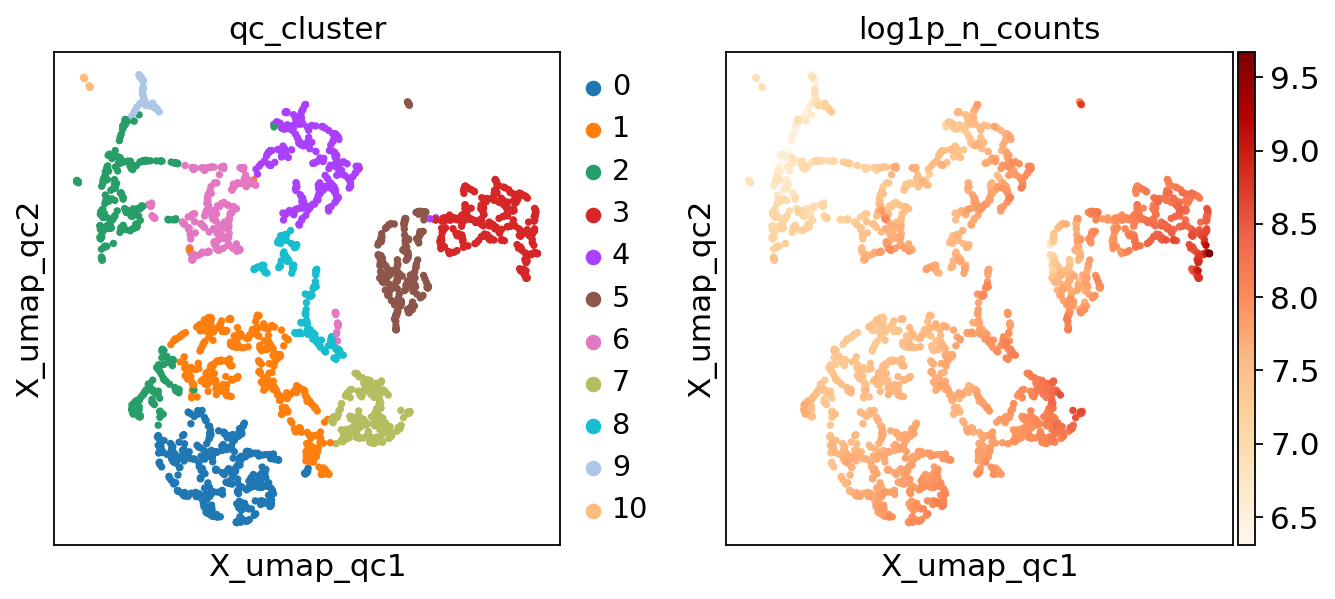

In [5]:
sc.pl.embedding(adata, "X_umap_qc", color=["qc_cluster", "log1p_n_counts"], color_map="OrRd")

The next step of the workflow involves determining which of the cells pass QC individually.

In [6]:
sctk.filter_qc_outlier(adata)
adata

n_counts: [959.4421576429211, 15844.0029296875], 2563/2700 passed
n_genes: [320.5358429786537, 3421.998779296875], 2678/2700 passed
percent_mito: [0.0, 5.943145075272779], 2674/2700 passed
percent_ribo: [13.568207997582016, 51.07162303563632], 2627/2700 passed
percent_hb: [0.0, 0.002321736026317521], 2375/2700 passed
2184/2700 pass


AnnData object with n_obs × n_vars = 2700 × 32738
    obs: 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'qc_cluster', 'good_qc_cell'
    var: 'gene_ids', 'mito', 'ribo', 'hb', 'n_counts', 'n_cells'
    uns: 'qc_cluster_colors'
    obsm: 'X_umap_qc'

There's now a `good_qc_cell` column in `.obs` which features per-cell QC calls. `True` is good, `False` is bad.

In [7]:
adata.obs['good_qc_cell'].sum()

2184

Controlling the desired QC thresholds requires a bit of explanation.

Under the hood, `sctk.filter_qc_outlier()` models each of the specified QC metrics as a Gaussian mixture model, with the model proposing possible low and high value cutoffs at points where the probability density function of the mixture falls below a threshold (0.05 by default). The function is written to allow robust filtering, requiring a specific formatting of `metrics`. The default values are:

```
metrics = {
    "n_counts": (1000, None, "log", "min_only", 0.1),
    "n_genes": (100, None, "log", "min_only", 0.1),
    "percent_mito": (0.01, 20, "log", "max_only", 0.1),
    "percent_ribo": (0, 100, "log", "both", 0.1),
    "percent_hb": (None, 1, "log", "max_only", 0.1),
    "percent_soup": (None, 5, "log", "max_only", 0.1),
    "percent_spliced": (50, 97.5, "log", "both", 0.1),
    "scrublet_score": (None, 0.3, "linear", "max_only", 0.95),
}
```

The variable is a dictionary, with keys named after computed QC metrics present in the `.obs` of the input object. Values absent from `.obs` will get skipped (so in our case, `percent_soup`, `percent_spliced` and `scrublet_score` all got bypassed when we ran the function). The value is a five-element tuple controlling the input to the GMM and subsequent filtering behaviour:
 - the minimum value to use in modelling the distribution; values lower than this will be skipped; set to `None` to use the encountered minimum
 - the maximum value to use in modelling the distribution; values higher than this will be skipped; set to `None` to use the encountered maximum
 - `"log"` to log-transform the QC metric values prior to modelling, `"linear"` to keep the values un-transformed
 - `"min_only"` to only perform filtering of low values, `"max_only"` to only perform filtering of high values, `"both"` to perform filtering from both sides
 - the minimum proportion of cells that need to pass the filtering on this feature; if the fraction is too low, the GMM is discarded and the QC values are thresholded based on the provided minimum/maximum

As the function goes along, it prints out the actual QC metric value ranges it used in filtering, and how many cells fall within that range. For example, notice how we specified a 100-gene minimum for the modelling, but the proposed data-driven cutoff ends up being 320.

Let's try out modifying the `metrics` values by removing the three measures absent from our object, and increasing the `n_genes` minimum to 500.

In [8]:
metrics = {
    "n_counts": (1000, None, "log", "min_only", 0.1),
    "n_genes": (500, None, "log", "min_only", 0.1),
    "percent_mito": (0.01, 20, "log", "max_only", 0.1),
    "percent_ribo": (0, 100, "log", "both", 0.1),
    "percent_hb": (None, 1, "log", "max_only", 0.1),
}

sctk.filter_qc_outlier(adata, metrics=metrics)

n_counts: [959.4421576429211, 15844.0029296875], 2563/2700 passed
n_genes: [495.3027116195289, 3421.998779296875], 2486/2700 passed
percent_mito: [0.0, 5.943145075272779], 2674/2700 passed
percent_ribo: [13.568207997582016, 51.07162303563632], 2627/2700 passed
percent_hb: [0.0, 0.002321736026317521], 2375/2700 passed
2118/2700 pass


The gene count filtering is different now, as expected.

The final step of the workflow determines computes a fraction of passing cells for each cluster. If a cluster has a high enough fraction of passing cells (controlled via the `threshold` parameter, default 0.5), it's deemed to be a good QC cluster.

You can use your own per-cell QC calls here rather than the ones provided by `sctk.filter_qc_outlier()` if desired, just specify which `.obs` column to take via the `cell_qc_key` argument.

In [9]:
sctk.find_good_qc_cluster(adata)
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    obs: 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'qc_cluster', 'good_qc_cell', 'good_qc_clusters'
    var: 'gene_ids', 'mito', 'ribo', 'hb', 'n_counts', 'n_cells'
    uns: 'qc_cluster_colors'
    obsm: 'X_umap_qc'

The `good_qc_clusters` column is similar to the `good_qc_cell` one - `True` is good, `False` is bad. We can visualise the distribution of both cell-level and cluster-level QC on the embedding made earlier.

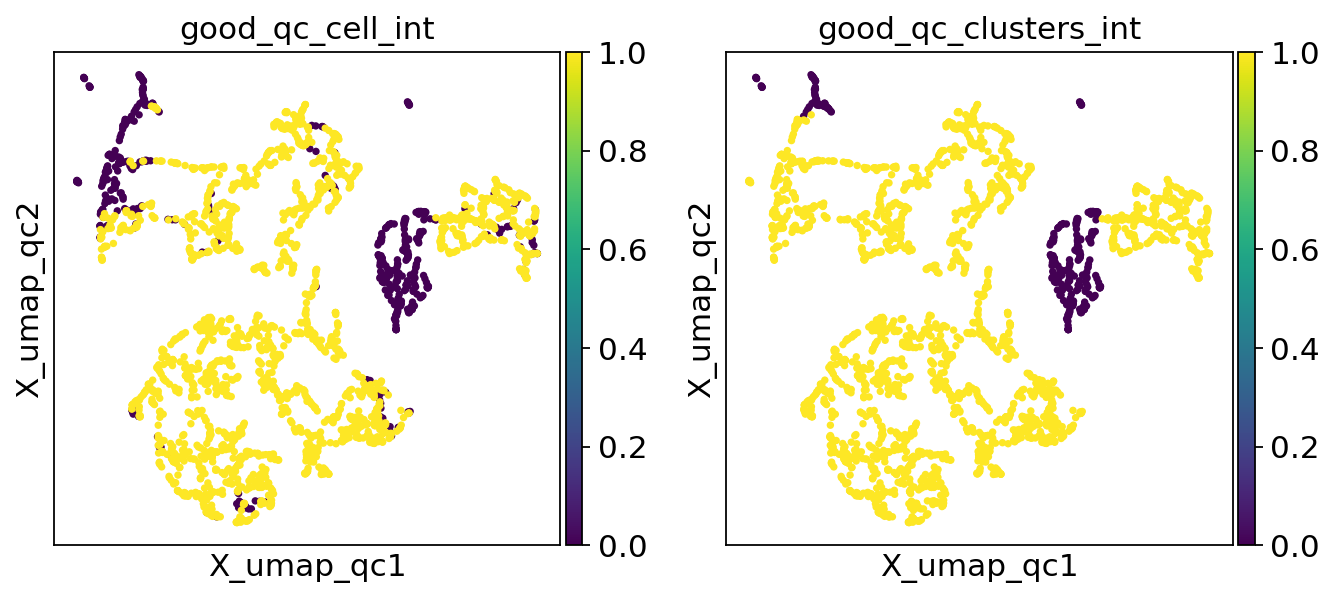

In [10]:
#this won't be necessary in scanpy 1.10.0, booleans will become directly plottable
for col in ['good_qc_cell', 'good_qc_clusters']:
    adata.obs[col+"_int"] = adata.obs[col].astype(int)
sc.pl.embedding(adata, "X_umap_qc", color=["good_qc_cell_int", "good_qc_clusters_int"])

We seem to get a nontrivial number of cells individually flagged as poor quality colocating in the top left of the plot, but only a small subset of them remain after cluster membership is leveraged. Let's generate a new set of QC clusters by increasing the resolution parameter value, creating a higher number of smaller clusters as a result.

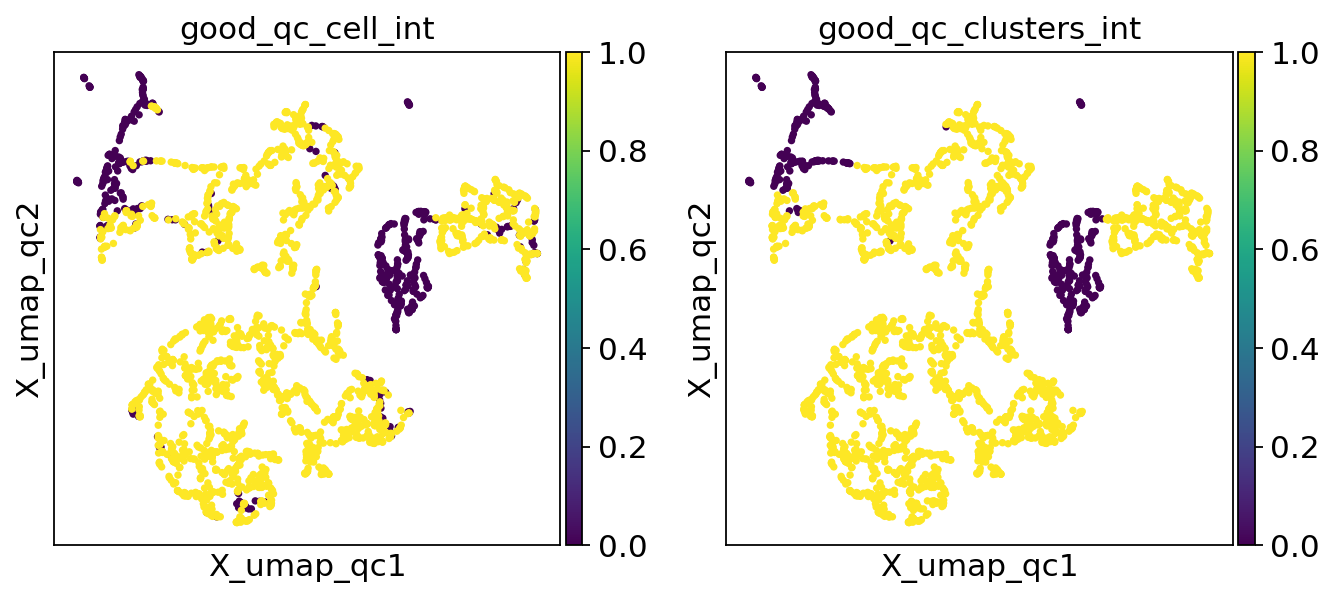

In [11]:
sctk.generate_qc_clusters(adata, metrics = metrics_list, res=1)
sctk.find_good_qc_cluster(adata)

#this won't be necessary in scanpy 1.10.0, booleans will become directly plottable
for col in ['good_qc_cell', 'good_qc_clusters']:
    adata.obs[col+"_int"] = adata.obs[col].astype(int)
sc.pl.embedding(adata, "X_umap_qc", color=["good_qc_cell_int", "good_qc_clusters_int"])

The plots align better now.

At this point you should be able to use the QC workflow on your own data.